# Sections

- [Read data](#read_data)
    * [Read counts data](#read_counts_data)
    * [Read Mid-probability table](#read_Mid-probability_table)
- [Hypothesis I](#hypothesis1)
- [Hypothesis III](#hypothesis3)
    * [Reproduce results](#reproduce_results_hypothesis3)
    * [Test for individuals in the lab](#individuals_hypothesis3)
- [Terminal Digits Analysis](#tda)
    * [Reproduce results](#reproduce_tda)
    * [Test for individuals in the lab](#individuals_tda)
- [Equal Digits Analysis](#eda)
    * [Reproduce results](#reproduce_eda)
    * [Test for individuals in the lab](#individuals_eda)
    
- [Terminal digit assumption](#td_assumption)
- [Permutation test](#permutation_test)
    * [Terminal digit analysis](#terminal_digit_analysis)
    * [Equal digit analysis](#equal_digit_analysis)
- [Tables and figures](#tablesFigures)
    * [Table 1](#table1)
    * [Figure 1](#figure1)
    * [Poisson test](#Poisson_test)

- [Tests](#tests)

In [1]:
from __future__ import division, generators, absolute_import, print_function

import numpy as np
import scipy.stats
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = '../data/'

<a id='read_data'></a>
# Read Data

<a id='read_counts_data'></a>
## Read counts data

In [122]:
def read_data(data_dir, file_name, skiprows, triple_col):
    """
    This function reads data from xlsx file
    
    Parameters
    ----------
        data_dir: string
            data directory
        file_name: string
            xlsx file name
        skiprows: int
            rows to skip at the beginning
        triple_col: list of string
            a list of length 3, the column name for the triple in the xlsx file
    
    Returns
    -------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    """
    df = pd.read_excel(data_dir + file_name, skiprows = skiprows)
    df[triple_col] = df[triple_col].apply(
        lambda x: pd.to_numeric(x, errors='coerce'))
    col_name = ['col1', 'col2', 'col3']
    df = df.rename(columns = {triple_col[0]: col_name[0],
                              triple_col[1]: col_name[1],
                              triple_col[2]: col_name[2]})
    return df

In [123]:
def filter_na_triple(df):
    """
    This function remove triples with missing values
    
    Parameters
    ----------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    
    Returns
    -------   
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            triples with missing values are removed
    """
    df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    nan_index = df[col_name].apply(np.isnan).any(1).nonzero()[0]
    df = df.drop(df.index[nan_index])
    df = df.reset_index(drop=True) 
    return df

In [124]:
def filter_gap_2(df):
    """
    This function sort each triple by increasing order, and 
    triples with gap less than or equal to 1 are filtered out
    
    Parameters
    ----------
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
    
    Returns
    -------   
        df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            each triple is sorted by increasing order,
            triples with gap less than or equal to 1 are filtered out
    """
    
    df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    nan_index = df[col_name].apply(np.isnan).any(1).nonzero()[0]
    df = df.drop(df.index[nan_index])
    df = df.reset_index(drop=True)
    
    # sort each triple by increasing order
    df[col_name] = df[col_name].apply(np.sort, axis = 1)
    
    # filter out the triples with gap less than or equal to 1
    complete_index = df[col_name].apply(
        lambda x: x.col3 - x.col1 <=1, axis=1).nonzero()[0]
    df = df.drop(df.index[complete_index])
    df = df.reset_index(drop=True)
    
    return df

<a id='readfromxls'></a>

In [16]:
def ReadFromXls(file, cols, rows, types, sorted = True, verbose = True):
    '''
     Read file.xlsx and extract a 2d list 
     Written by BigRabbit.
     Inputs:
       file    : str of file location
       cols    : list/tuple of selected columns
       rows    : list/tuple of selected rows
       types   : a tuple of allowed types, e.g. (int, long)
       sorted  : boolean whether to sort each row (only valid when types are numerics)
       verbose : boolean whether to print what's going on
     Output:
       a 2d list of integers
    '''
    if verbose: print('****** ReadFromXls: Read file.xlsx and extract a 2d list *****')
    from openpyxl import load_workbook
    wb  = load_workbook(file) 
    if verbose: print('-- Opened file:', file)
    if verbose: print('-- Sheet names:', wb.get_sheet_names(), 'Using Sheet1 as default.')
    ws = wb.get_sheet_by_name('Sheet1')
    if verbose: print('-- A1 (typically the title):', ws['A1'].value)
    rawData = []
    for i in rows:
        oneRow = []
        for j in cols:
            entry = ws[j + str(i)].value
            if isinstance(entry, types):
                oneRow.append(entry)
            else:
                break
        if len(oneRow) == len(cols):
            if sorted: oneRow.sort()
            rawData.append(oneRow)
    if verbose: print('-- successfully read ', len(rawData), 'full lines!')
    if verbose: print('************************ finished. *************************')
    return rawData

Read colony data from RTS, other invectigators in the lab and outside lab 3.

In [138]:
# colony data: RTS
rts_colony = read_data(
    data_dir, 'Bishayee Colony Counts 10.27.97-3.8.01.xlsx', 
    skiprows=2, triple_col=['col1', 'col2', 'col3'])

# colony data: other invectigators in the lab
inv_colony = read_data(
    data_dir, 'Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx', 
    skiprows=1, triple_col=['col1', 'col2', 'col3'])

# colony data: outside lab
lab_colony = read_data(
    data_dir, 'Outside Lab 3.Colony Counts.2.4.10-5.21.12.xlsx', 
    skiprows=1, triple_col=['c1', 'c2', 'c3'])

Read coulter data from RTS, other invectigators in the lab and outside lab 1 and 2.

In [139]:
# coulter data: RTS
rts_coulter = read_data(
    data_dir, 'Bishayee Coulter Counts.10.20.97-7.16.01.xlsx', 
    skiprows=1, triple_col=['Count 1', 'Count 2', 'Count 3'])

# coulter data: other invectigators in the lab
inv_coulter = read_data(
    data_dir, 'Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx', 
    skiprows=1, triple_col=['Coul 1', 'Coul 2', 'Coul 3'])

# coulter data: outside lab1
lab1_coulter = read_data(
    data_dir, 'Outside Lab 1.Coulter Counts.6.7.91-4.9.99.xlsx', 
    skiprows=0, triple_col=['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'])

# coulter data: outside lab2
lab2_coulter = read_data(
    data_dir, 'Outside Lab 2.Coulter Counts.6.6.08-7.7.08.xlsx', 
    skiprows=1, triple_col=['Count 1', 'Count 2', 'Count 3'])

As a sanity check, we count the number of triples in each data set as follows. The **No. triples** shows the number of triples without missing values and the **No. complete** shows the number of triples after we removing the triples with gap less than or equal to 1. Our results disagree with the number persented in the paper in the following entries (blue shows our results). 

|	         | No. triples	|No. complete |
|------------|--------------|-------------|
|inv_colony  |591(<font color='blue'>597</font>)  |572(<font color='blue'>578</font>)|
|rts_coulter |1717(<font color='blue'>1727</font>)|1716(<font color='blue'>1726</font>)|

In [10]:
no_triples = pd.DataFrame(columns=("No. triples", "No. complete"))
for dfs in ["rts_colony", "inv_colony", "lab_colony",
            "rts_coulter", "inv_coulter", "lab1_coulter", "lab2_coulter"]:
    no_triples.loc[dfs] = (len(filter_na_triple(eval(dfs))), 
                           len(filter_gap_2(eval(dfs))))
no_triples

,No. triples,No. complete
rts_colony,1361.0,1343.0
inv_colony,597.0,578.0
lab_colony,50.0,49.0
rts_coulter,1727.0,1726.0
inv_coulter,929.0,929.0
lab1_coulter,97.0,97.0
lab2_coulter,120.0,120.0


<a id='read_Mid-probability_table'></a>
## Read Mid-probability table

In [11]:
# read the mid probability table from output directory
# mid probability table: the mid-containing probability for different 
# values of lambdas
output_dir = "../outputs/"
midProb = np.loadtxt(output_dir + "MidProb.txt", delimiter="\t")
midProb.shape

(2129, 2)

<a id='hypothesis1'></a>
# Hypothesis I
require read data function [ReadFromXls](#readfromxls)

In [17]:
from scipy.stats import binom
file = '../data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx'
rawData2 = ReadFromXls(file, ('C', 'D', 'E', 'F'), rows = range(3, 623), types = (int, str), sorted = False, verbose=False)
invs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
test1 = pd.DataFrame(columns = ('No. Obs.', 'No. Mid', 'p-value Upper bound'))
test1.loc['RTS']  = ('%d' % 1343, '%d' %  690, '%.2e' % (1 - binom.cdf(690 - 1, 1343, 0.42)))
test1.loc['Else'] = ('%d' % 572, '%d' % 109, '%.2e' % (1 - binom.cdf(109 - 1,  572, 0.42)))
for name in invs:
    data = [x[1:4] for x in rawData2 if x[0] == name]
    data = [x for x in data if isinstance(x[0], int) and isinstance(x[1], int) and isinstance(x[2], int)] # filter out empty
    data = [np.sort(x) for x in data] # sort each row from small to big
    data = [x for x in data if x[2] - x[0] > 1] # filter out gap < 2
    containMean = [x for x in data if int((x[0] + x[1] + x[2])/3) == int(x[1])]
    test1.loc[name] = ('%d' % len(data), '%d' % len(containMean), '%.2e' % (1 - binom.cdf(len(containMean) - 1, len(data), .42)))
test1

,No. Obs.,No. Mid,p-value Upper bound
RTS,1343,690,2.85e-12
Else,572,109,1.00e+00
A,248,47,1.00e+00
B,56,8,1.00e+00
C,85,20,1.00e+00
D,77,11,1.00e+00
E,10,1,9.96e-01
F,29,3,1.00e+00
G,7,1,9.78e-01
H,21,0,1.00e+00


In [ ]:
invs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
plt.figure(figsize=(18, 6))
for i in range(0, 9):
    name = invs[i - 1]
    data = [x[1:4] for x in rawData2 if x[0] == name]
    data = [x for x in data if isinstance(x[0], int) and isinstance(x[1], int) and isinstance(x[2], int)] # filter out empty
    data = [np.sort(x) for x in data] # sort each row from small to big
    data = [x for x in data if x[2] - x[0] > 1] # filter out gap < 2
    midRatio = [(x[1] - x[0])/(x[2] - x[0]) for x in data]
    plt.subplot(3, 3, i + 1)
    plt.hist(midRatio, [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01],
                                 rwidth=0.5)


(array([ 102.,   79.,   99.,  115.,  121.,  108.,  103.,  108.,   79.,   76.]),
 array([ 0.   ,  0.101,  0.201,  0.301,  0.401,  0.501,  0.601,  0.701,
         0.801,  0.901,  1.01 ]),
 <a list of 10 Patch objects>)

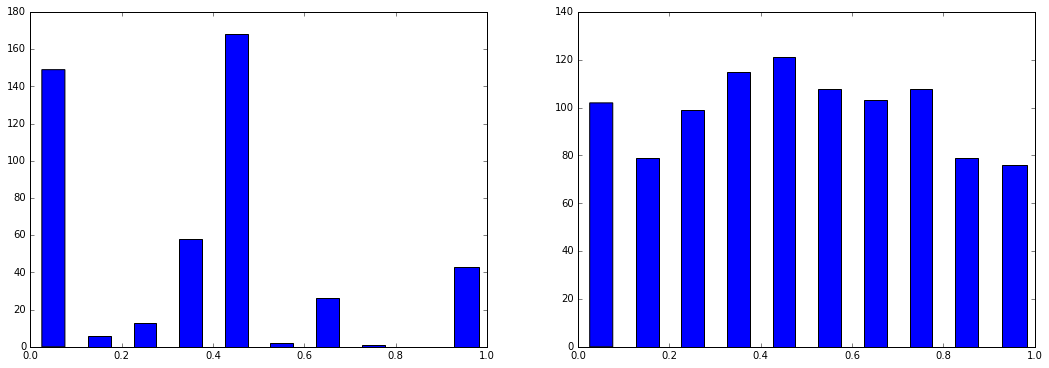

In [14]:
simuTriples = [np.sort(np.random.poisson(lam=i, size=3).tolist()) for i in [1] * 1000]
simuTriples = [x for x in simuTriples if x[2] > x[0] + 1]
midRatio  = [(x[1] - x[0])/(x[2] - x[0]) for x in simuTriples]
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(midRatio,  [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01],
                                 rwidth=0.5)

simuTriples = [np.sort(np.random.poisson(lam=i, size=3).tolist()) for i in [100] * 1000]
simuTriples = [x for x in simuTriples if x[2] > x[0] + 1]
midRatio  = [(x[1] - x[0])/(x[2] - x[0]) for x in simuTriples]
plt.subplot(1, 2, 2)
plt.hist(midRatio,  [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01],
                                 rwidth=0.5)

<a id='hypothesis3'></a>
# Hypothesis III

Hypothesis 3 use the Lindeberg-Feller Central Limit Theorem to approximate the distribution of occurrences of mean containing triples. 

- They use the mean of triples as the estimation of the Poission distribution parameters $\lambda$. 
- The probability of mean-containing $p_i$ in each triple thus can be retrieved from mid-probability table according to the estimated lambda.
- The number of mean containing triples are treated as sum of Bernoulli variables. Using Lindeberg-Feller Central Limit Theorem, the expectation and the variance are approximated using $\sum_{i = 1}^np_i$ and $\sum_{i = 1}^np_i(1-p_i)$.


However, the approximation of expectation and the variance is not precise because of the following reasons:

- The Poisson distribution assumption remains unverified.
- The author use the mean of each triple as the estimation is Poisson distribution parameter. Although this estimation is unbiased, the MSE (variance) would be large: $MSE(\hat\lambda) = Var(\hat\lambda) = 1/9(\sum ^3_{i = q}Var(X_i)) = 1/3\lambda$. And there is no prove showing that the $p_i$ would be the unbiased estimation. Thus, it is rather inappropriate to use the Lindeberg-Feller CLT. The p-value obtained using this method would could vary a lot from the true p-value.

In [10]:
def hypothesis_3(df, midProb, print_res=False):
    """
    This function implements the hypothesis test 3 for mean-containing 
    ratio in the paper.
    
    Parameters
    ----------
        filtered_df: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3,
            each triple is sorted by increasing order,
            triples with gap less than or equal to 1 are filtered out
        midProb: numpy.ndarray
            mid probability table, the mid-containing probability for 
            different values of lambdas
        print_res: default False
            False: print all the results
            True: return number of mean containing triples, mean and sd
                of poission binomial, Z statistic and p-value without printing
    """
    filtered_df = df.copy(deep=True)
    col_name = ['col1', 'col2', 'col3']
    
    # sort each triple by increasing order
    filtered_df[col_name] = filtered_df[col_name].apply(np.sort, axis = 1)
    
    # whether the mid number is the mean of largest and smallest
    isMid = filtered_df.apply(
        lambda x: x.col1 + x.col3 in [2*x.col2, 2*x.col2 + 1, 2*x.col2 - 1], axis=1)
    
    # rounded mean triple as the estimate of lambda
    lamEst = np.mean(filtered_df[col_name], axis=1)
    # probabiliy that the triple been randomly drawn it would contain its own mean
    lams = np.array([i[0] for i in midProb])
    probs = [midProb[np.argmin(abs(lams-i))][1] for i in lamEst]
    
    # expectation and variance of poisson binomial
    mu = np.sum(probs)
    sigma2 = np.sum(p*(1-p) for p in probs)
    
    # compute statistic and p-value for hypothesis 3
    stat3 = (sum(isMid) - 0.5 - mu) / np.sqrt(sigma2)
    p_value3 = 1 - scipy.stats.norm.cdf(stat3)
    
    if print_res:
        print("Number of mean containing triples: ", sum(isMid))
        print("Mean of poission binomial: ", mu)
        print("SD of poission binomial: ", np.sqrt(sigma2))
        print("Z statistic: ", stat3)
        print("p-value: ", p_value3)
    else:
        return len(filtered_df), sum(isMid), mu, np.sqrt(sigma2), stat3, p_value3

<a id='reproduce_results_hypothesis3'></a>
## Reproduce results

Our reproduce results differs from what presented in the Table 2 in the paper. The authors seems to have made a small mistake. While their number of mean-containing triples is obtained from the filtered data (with gap less than 2 filtered out), their number of triples expected is calculated using the data before filtering. This mistake results in larger p-values for other investigators and outside labs and increases the cheating suspicion of RTS.

The following table shows the summary results for analysis of mean containing triples for colony and Coulter count triples from RTS, nine other investigators from the same lab, and investigators in outside labs. Note that the No. mean containing agrees with the paper but the stastistics differs from the paper.

In [11]:
# No. complete: number of complete triples with gap ≥2/ total number of triples;
# No. mean containing: number of mean-containing triples
# No. expected: Number of mean containing triple expected using Poisson binomial distribution
# sd: standard devistion of No. expected
# Z: Z statistics from Lindeberg-Feller Central Limit Theorem

hypothesis_3_res = pd.DataFrame(columns=('No. complete', 'No. mean containing', 
                                         'No. expected', "sd", "Z", "p-value"))
for dfs in ["rts_colony", "inv_colony", "lab_colony",
            "rts_coulter", "inv_coulter", "lab1_coulter", "lab2_coulter"]:
    hypothesis_3_res.loc[dfs] = hypothesis_3(filter_gap_2(eval(dfs)), midProb)
hypothesis_3_res

,No. complete,No. mean containing,No. expected,sd,Z,p-value
rts_colony,1343.0,690.0,214.923602,13.281792,35.731353,0.000000e+00
inv_colony,578.0,109.0,103.404567,9.061666,0.562306,2.869536e-01
lab_colony,49.0,3.0,7.788269,2.554401,-2.070258,9.807859e-01
rts_coulter,1726.0,176.0,98.367748,9.612620,8.024061,5.551115e-16
inv_coulter,929.0,36.0,39.851416,6.107390,-0.712484,7.619174e-01
lab1_coulter,97.0,0.0,4.430351,2.033995,-2.423974,9.923241e-01
lab2_coulter,120.0,1.0,3.752921,1.897438,-1.714375,9.567701e-01


The following cell shows the summary results for analysis of mean containing triples for colony count triples from RTS. Dataset before filtering is used. Mean(220.31) and sd(13.42) of poission binomial coincide with Table 2 in paper, which suggests a problem.

In [13]:
hypothesis_3(filter_na_triple(rts_colony), midProb, print_res=True)

Number of mean containing triples:  708
Mean of poission binomial:  220.313684239
SD of poission binomial:  13.4181445464
Z statistic:  36.3080241145
p-value:  0.0


Summary results for analysis of mean containing triples for colony count triples from other invectogators in the lab. Dataset before filtering is used. Mean(108.5) and sd(9.26) of poission binomial are close to Table 2 in paper, which suggests a problem.

In [14]:
hypothesis_3(filter_na_triple(inv_colony), midProb, print_res=True)

Number of mean containing triples:  128
Mean of poission binomial:  108.501276257
SD of poission binomial:  9.25874114803
Z statistic:  2.05197698475
p-value:  0.0200859495977


<a id='individuals_hypothesis3'></a>
## Test for individuals in the lab

The following two tables shows the results of hypothesis test 3 for colony and coulter triples from other investigators individually in the lab. Under a commonly used threshhold 0.05, investigator C would also be rejected by the null hypothesis.

In [16]:
# colony data: Test for individuals in the lab
hypothesis_3_ind = pd.DataFrame(columns=('No. complete', 'No. mean containing', 
                                         'No.expected', "sd", "Z", "p-value"))
filtered_inv_colony = filter_gap_2(inv_colony)
for inv in set(filtered_inv_colony.Inv):
    hypothesis_3_ind.loc[inv] = hypothesis_3(
        filtered_inv_colony.loc[filtered_inv_colony.Inv == inv].copy(), midProb)
hypothesis_3_ind

,No. complete,No. mean containing,No.expected,sd,Z,p-value
H,21.0,1.0,2.827193,1.554125,-1.497429,0.932859
E,10.0,2.0,1.306389,1.059426,0.182751,0.427497
I,44.0,8.0,7.818411,2.480351,-0.128373,0.551073
C,85.0,25.0,17.189069,3.656139,1.999632,0.022770
A,248.0,42.0,44.087806,5.895250,-0.438965,0.669656
G,8.0,4.0,1.829225,1.179072,1.417026,0.078238
B,56.0,8.0,9.622682,2.790427,-0.760701,0.776582
F,29.0,6.0,5.139362,2.020507,0.178489,0.429169
D,77.0,13.0,13.584431,3.323176,-0.326324,0.627910


In [17]:
# coulter data: Test for individuals in the lab
hypothesis_3_ind = pd.DataFrame(columns=('No. complete', 'No. mean containing', 
                                         'No.expected', "sd", "Z", "p-value"))
filtered_inv_coulter = filter_gap_2(inv_coulter)
for inv in set(filtered_inv_coulter.Investigator):
    hypothesis_3_ind.loc[inv] = hypothesis_3(
        filtered_inv_coulter.loc[filtered_inv_coulter.Investigator == inv].copy(), midProb)
hypothesis_3_ind

,No. complete,No. mean containing,No.expected,sd,Z,p-value
E,55.0,5.0,4.671003,2.044958,-0.083622,0.533321
I,51.0,1.0,2.142147,1.431972,-1.146773,0.874262
C,25.0,0.0,0.804557,0.878638,-1.484750,0.931195
A,405.0,17.0,16.221240,3.905996,0.071367,0.471553
G,20.0,1.0,0.701662,0.822601,-0.245152,0.596831
B,60.0,2.0,3.402493,1.789613,-1.063075,0.856126
F,102.0,5.0,5.852532,2.322407,-0.582384,0.719846
D,211.0,5.0,6.055781,2.401259,-0.647902,0.741476


<a id='tda'></a>
# Terminal Digit Analysis

<a id='reproduce_tda'></a>
## Reproducibility

Here we reproduce a test implemented by the authors to investigate whether the RTS data has a significant deviation in the distribution of "terminal digits" (i.e., the ones place in count data). The authors used a $\chi^2$ test with 9 degrees of freedom:
    
$$ \chi^2_9 = \sum\limits_{i=0}^9 \frac{(O_i-E_i)^2}{E_i} $$
    
Where $O_i$ and $E_i$ are the observed and expected frequency of counts of digit $i$. 

Note that the authors assume $E_i = 0.1 \,\, \forall i \in \{0,..,10\}$; please see our test of the [terminal digit uniformity assumption](#td_assumption) for our investigation of this assumption.

The following function takes count data as input and outputs 1) its $\chi^2$ statistic and 2) its p-value. We ignore blank cells in the authors' spreadsheets.

We found minor discrepancies in our calculation of the statistic; we assume this was 

In [49]:
def terminal_digit_analysis(data):
    '''
    data is a list of ints
    returns chisq, p
    '''
    freqs = np.zeros(10)
    for entry in data:
        if np.isnan(entry):
            continue

        dig = entry % 10
        freqs[dig] += 1
    
    # calculate chisq
    chisq=0
    for d in range(0,10):
        chisq += (freqs[d]-0.1*np.sum(freqs))**2/(0.1*np.sum(freqs))
        
    return[chisq,1-scipy.stats.chi2.cdf(chisq,9)]


In [50]:
def df_to_list(df):
    '''
    converts df to a simple list of cols 1-3.
    '''
    return list(df.loc[:,'col1']) + list(df.loc[:,'col2']) + list(df.loc[:,'col3'])

### Colony counts

In [97]:
# get lists of counts
rts_colony_counts = df_to_list(rts_colony)
inv_colony_counts = df_to_list(inv_colony)
lab_colony_counts = df_to_list(lab_colony)

In [197]:
# perform test
df = pd.DataFrame(index=['RTS','Same lab','Other lab'],columns=['ChiSq','p'])
res = terminal_digit_analysis(rts_colony_counts)
df.loc['RTS','ChiSq'] = res[0]
df.loc['RTS','p'] = res[1]

res = terminal_digit_analysis(inv_colony_counts)
df.loc['Same lab','ChiSq'] = res[0]
df.loc['Same lab','p'] = res[1]

res = terminal_digit_analysis(lab_colony_counts)
df.loc['Other lab','ChiSq'] = res[0]
df.loc['Other lab','p'] = res[1]

print(df.to_latex())

\begin{tabular}{lll}
\toprule
{} &    ChiSq &         p \\
\midrule
RTS       &  200.726 &         0 \\
Same lab  &  1.79062 &  0.994363 \\
Other lab &  12.1333 &  0.205897 \\
\bottomrule
\end{tabular}



/Users/ajstern/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Coulter counts

In [53]:
# get lists of counts
rts_coulter_counts = df_to_list(rts_coulter)
inv_coulter_counts = df_to_list(inv_coulter)
lab1_coulter_counts = df_to_list(lab1_coulter)
lab2_coulter_counts = df_to_list(lab2_coulter)

In [195]:
# perform test
df = pd.DataFrame(index=['RTS','Same lab','Other lab 1','Other lab 2'],columns=['ChiSq','p'])
res = terminal_digit_analysis(rts_coulter_counts)
df.loc['RTS','ChiSq'] = res[0]
df.loc['RTS','p'] = res[1]

res = terminal_digit_analysis(inv_coulter_counts)
df.loc['Same lab','ChiSq'] = res[0]
df.loc['Same lab','p'] = res[1]

res = terminal_digit_analysis(lab1_coulter_counts)
df.loc['Other lab 1','ChiSq'] = res[0]
df.loc['Other lab 1','p'] = res[1]

res = terminal_digit_analysis(lab2_coulter_counts)
df.loc['Other lab 2','ChiSq'] = res[0]
df.loc['Other lab 2','p'] = res[1]

print(df.to_latex())


\begin{tabular}{lll}
\toprule
{} &    ChiSq &          p \\
\midrule
RTS         &  466.875 &          0 \\
Same lab    &  15.9946 &  0.0669952 \\
Other lab 1 &  9.47619 &   0.394527 \\
Other lab 2 &  4.94444 &   0.839124 \\
\bottomrule
\end{tabular}



/Users/ajstern/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<a id='individuals_tda'></a>
## Individual-stratified terminal digit analysis

We augmented the authors' study by stratifying the lumped group of other investigators from the same lab as RTS. We calculate a chi square test for their terminal digit frequencies individually. Individuals are denoted by letters (e.g. "A"). Sample size $N$ denotes number of cell counts used in the calculation of that individuals' statistic.

Our results show that Investigator D appears to have a suspicious distribution of terminal digits recorded from the Coulter machine.

### Colony counts

In [74]:
df = pd.DataFrame(index=list(set(inv_colony.Inv)),columns=['ChiSq','p','N'])
for inv in set(inv_colony.Inv):
    inv_data = df_to_list(inv_colony.loc[inv_colony.Inv == inv].copy())
    res = terminal_digit_analysis(inv_data)
    df.loc[inv,'ChiSq'] = res[0]
    df.loc[inv,'p'] = res[1]
    df.loc[inv,'N'] = len(inv_data)
df

/Users/ajstern/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,ChiSq,p,N
A,6.91784,0.645673,789
C,4.90406,0.84259,273
B,13.3563,0.147135,174
E,5.33333,0.804337,30
D,8.48,0.486588,255
G,9.33333,0.407091,30
F,5.33333,0.804337,96
I,6.53741,0.685157,153
H,14.3016,0.111994,63


In [194]:
df = pd.DataFrame(index=list(set(inv_coulter.Investigator)),columns=['ChiSq','p','N'])
for inv in set(inv_coulter.Investigator):
    inv_data = df_to_list(inv_coulter.loc[inv_coulter.Investigator== inv].copy())
    res = terminal_digit_analysis(inv_data)
    df.loc[inv,'ChiSq'] = res[0]
    df.loc[inv,'p'] = res[1]
    df.loc[inv,'N'] = len(inv_data)
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} &    ChiSq &           p &     N \\
\midrule
A &  8.10232 &    0.523869 &  1401 \\
C &  14.5789 &     0.10317 &   105 \\
B &  5.88889 &    0.750985 &   180 \\
E &  9.12121 &    0.426161 &   165 \\
D &  21.8438 &  0.00938759 &   645 \\
G &  5.33333 &    0.804337 &    60 \\
F &  6.96774 &    0.640478 &   312 \\
I &   9.4183 &    0.399591 &   153 \\
\bottomrule
\end{tabular}



/Users/ajstern/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<a id='eda'></a>
# Equal Digit Analysis

<a id='reproduce_eda'></a>
## Reproducibility

First, we attempted to reproduce the authors' analysis of frequency of terminal digit pairs (e.g., '66') in the data. This test assumes that equal digits pairs are equally likely and that the probability of any (3+)-digit number having equal terminal digits is 10%. So, counts of equal-digit-pair-containing numbers can be assumed to be distributed $\sim \text{Binom}(0.10,N)$.

As the authors did, we only analyze the Coulter data, which have higher counts. Our results show minor inconsistencies with the statistics calculated by the authors -- we suspect this may be the result of different filtering.

In [89]:
def equal_digit_analysis(data):
    '''
    data is a list of ints
    returns chisq, p
    '''
    x = 0
    n = len(data)
    for entry in data:
        if np.isnan(entry):
            continue

        # filter numbers less than 100
        if entry < 100:
            continue 
            
        if (entry - entry % 10)/10 % 10  == entry % 10:
            x += 1
    
    return[x,1 - scipy.stats.binom.cdf(x,n,0.1),n]

In [90]:
# perform test
df = pd.DataFrame(index=['RTS','Same lab','Other lab 1','Other lab 2'],columns=['x','n','p'])
res = equal_digit_analysis(rts_coulter_counts)
df.loc['RTS','x'] = res[0]
df.loc['RTS','p'] = res[1]
df.loc['RTS','n'] = res[2]

res = equal_digit_analysis(inv_coulter_counts)
df.loc['Same lab','x'] = res[0]
df.loc['Same lab','p'] = res[1]
df.loc['Same lab','n'] = res[2]

res = equal_digit_analysis(lab1_coulter_counts)
df.loc['Other lab 1','x'] = res[0]
df.loc['Other lab 1','p'] = res[1]
df.loc['Other lab 1','n'] = res[2]

res = equal_digit_analysis(lab2_coulter_counts)
df.loc['Other lab 2','x'] = res[0]
df.loc['Other lab 2','p'] = res[1]
df.loc['Other lab 2','n'] = res[2]

df

,x,n,p
RTS,644,5187,8.57787e-09
Same lab,286,3021,0.827748
Other lab 1,32,327,0.504864
Other lab 2,30,360,0.83282


<a id='individuals_eda'></a>
## Individual-stratified equal digit analysis

We augmented the authors' study by stratifying the lumped Coulter data from other investigators in the same lab as RTS. We calculate binomial p-values for individuals.

We see that Investigator F appears to have a surprising enrichment for equal-digit pairs.

In [193]:
df = pd.DataFrame(index=list(set(inv_coulter.Investigator)),columns=['x','n','p'])
for inv in set(inv_coulter.Investigator):
    inv_data = df_to_list(inv_coulter.loc[inv_coulter.Investigator== inv].copy())
    res = equal_digit_analysis(inv_data)
    df.loc[inv,'x'] = res[0]
    df.loc[inv,'p'] = res[1]
    df.loc[inv,'n'] = res[2]
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} &    x &     n &          p \\
\midrule
A &  132 &  1401 &   0.748688 \\
C &    8 &   105 &   0.733914 \\
B &   16 &   180 &   0.634373 \\
E &   13 &   165 &   0.777841 \\
D &   62 &   645 &   0.597186 \\
G &    4 &    60 &   0.729042 \\
F &   40 &   312 &  0.0436366 \\
I &   11 &   153 &   0.848016 \\
\bottomrule
\end{tabular}



## Alternative digit pair test

We also tested enrichment for other digit pairs: for example, the pairs (09,10,21,...98). In this case, we see 3 other investigators who show approximately equally surprising frequencies of these pairs!

In [104]:
def other_digit_analysis(data):
    '''
    data is a list of ints
    returns chisq, p
    '''
    x = 0
    n = len(data)
    for entry in data:
        if np.isnan(entry):
            continue

        # filter numbers less than 100
        if entry < 100:
            continue 
            
        if (entry - entry % 10)/10 % 10  == (entry+1) % 10:
            x += 1
    
    return[x,1 - scipy.stats.binom.cdf(x,n,0.1),n]

In [192]:
df = pd.DataFrame(index=['RTS']+list(set(inv_coulter.Investigator)),columns=['x','n','p'])

res = other_digit_analysis(rts_coulter_counts)
df.loc['RTS','x'] = res[0]
df.loc['RTS','p'] = res[1]
df.loc['RTS','n'] = res[2]

for inv in set(inv_coulter.Investigator):
    inv_data = df_to_list(inv_coulter.loc[inv_coulter.Investigator== inv].copy())
    res = other_digit_analysis(inv_data)
    df.loc[inv,'x'] = res[0]
    df.loc[inv,'p'] = res[1]
    df.loc[inv,'n'] = res[2]
df.to_latex()

u'\\begin{tabular}{llll}\n\\toprule\n{} &    x &     n &          p \\\\\n\\midrule\nRTS &  560 &  5187 &   0.027532 \\\\\nA   &  156 &  1401 &  0.0738102 \\\\\nC   &   11 &   105 &    0.35797 \\\\\nB   &   23 &   180 &  0.0896297 \\\\\nE   &   10 &   165 &   0.947312 \\\\\nD   &   72 &   645 &   0.147142 \\\\\nG   &    6 &    60 &   0.393549 \\\\\nF   &   39 &   312 &  0.0624213 \\\\\nI   &   16 &   153 &   0.361155 \\\\\n\\bottomrule\n\\end{tabular}\n'

<a id='td_assumption'></a>
# Terminal digit uniformity assumption

Here we use simulations to examine the authors' claim that terminal digits of a Poisson r.v. are distributed uniformly. It appears that actually this assumption does not hold well for $\lambda < ~30$.

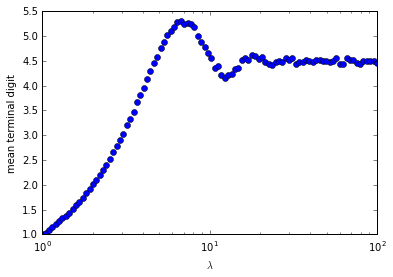

In [110]:
terminal_digit=[]
td_se = []
for l in np.logspace(0,2,100):
    digits = np.mod(np.random.poisson(l,size=10000),10)
    terminal_digit.append(np.mean(digits))
    
plt.semilogx(np.logspace(0,2,100),terminal_digit,'o')
plt.ylabel('mean terminal digit')
plt.xlabel(r'$\lambda$')

plt.savefig('/Users/ajstern/Documents/stat215a/stat215a-review/fig1.pdf',format='pdf')

<a id='permutation_test'></a>
# Permutation test

Both the terminal digit analysis and the equal digit analysis rely on the uniform distribution assumption of the terminal (or last two) digits. However, the uniform assumption may not hold. Some digit may have the larger chance of occurence than the others. 

In this section, we apply permutation test on terminal digit analysis and equal digit analysis, which does not rely on the dsitribution assumption.

<a id='terminal_digit_analysis'></a>
## Terminal digit analysis

For the terminal digit analysis, we use Chi-squared distance and Total Variation Distance (tvd) to measure the distance between two distributions. We compare the observed distance and the permuted distance distribution to obtain the p-value. 

In [180]:
def calc_distance(group1, group2):
    """
    This function calculate the distance between group1 and group2 using 
    Chi-squared distance and Total Variation Distance (tvd).
    
    Parameters
    ----------
        group1: list
            terminal digit list, which contains integers 0-9
        group2: list
            terminal digit list, which contains integers 0-9
    
    Returns
    -------
        tvd_obs: float
            Total Variation Distance
        chi_sq_obs: float
            Chi-squared distance
    """
    group1_obs = [group1.count(i)/len(group1) for i in range(10)]
    group2_obs = [group2.count(i)/len(group2) for i in range(10)]
    tvd_obs = 0.5*sum([abs(a_i - b_i) 
                       for a_i, b_i in zip(group1_obs, group2_obs)])
    chi_sq_obs = 0.5*sum([abs(a_i - b_i)**2/(a_i + b_i) 
                          for a_i, b_i in zip(group1_obs, group2_obs)])
    return tvd_obs, chi_sq_obs

In [190]:
def terminal_permutation(group1, group2, replication, plot = False):
    """
    This function apply permutation test on the terminal digits for two groups.
    The distance between two distribution are measured using Chi-squared distance 
    and Total Variation Distance (tvd).
    
    Parameters
    ----------
        group1, group2: pandas.core.frame.DataFrame
            pandas data frame with triple column named col1, col2 and col3
        replication: int
            replication times for permutation
        plot:
            if True, plot the histogram of permutated statitics and 
            observed statitics
    
    Returns
    -------
        tvd_obs: float
            observed tvd
        tvd_p_value:  float
            p-value calculated using tvd
        chi_sq_obs: float
            observed chi square distance
        chi_sq_p_value:  float
            p-value calculated using chi square distance
    """
    # obtain the terminal digits
    group1 = group1[['col1', 'col2', 'col3']].values.flatten()
    group1 = group1[~np.isnan(group1)]
    group1 = [np.mod(i, 10) for i in group1]
    group2 = group2[['col1', 'col2', 'col3']].values.flatten()
    group2 = group2[~np.isnan(group2)]
    group2 = [np.mod(i, 10) for i in group2]
    
    # observed distance between distribution
    tvd_obs, chi_sq_obs = calc_distance(group1, group2)
    
    # permutation
    tvd = []
    chi_sq = []
    for i in np.arange(replication):
        shuffled = random.sample(group1 + group2, 
                                 len(group1 + group2))
        tvd_shuffled, chi_sq_shuffled = calc_distance(shuffled[:len(group1)], 
                                                      shuffled[len(group1):])
        tvd.append(tvd_shuffled)
        chi_sq.append(chi_sq_shuffled)
        
    tvd_p_value = sum(np.array(tvd) > tvd_obs) / replication
    chi_sq_p_value = sum(np.array(chi_sq) > chi_sq_obs) / replication
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
        ax1.hist(tvd, bins=20, color='c')
        ax1.axvline(tvd_obs, color='b', linestyle='dashed', linewidth=2)
        ax1.set_title("TVD")
        ax2.hist(chi_sq, bins=20, color='c')
        ax2.axvline(chi_sq_obs, color='b', linestyle='dashed', linewidth=2)
        ax2.set_title("Chi squared distance")
        plt.show()
        #plt.savefig('/Users/ajstern/Documents/stat215a/stat215a-review/perm.pdf',format='pdf')
    return tvd_obs, tvd_p_value, chi_sq_obs, chi_sq_p_value

Permutation test of terminal digits between RTS colony data and other investigators colony data. The p values is close to zero, which indicate that the terminal digit distribution of RTS and other investigators in the lab are different.

(0.09260466984966408, 0.0, 0.011145925839597975, 0.0)

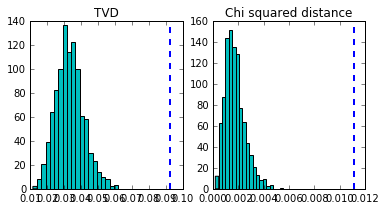

In [191]:
terminal_permutation(rts_colony, inv_colony, replication=1000, plot=True)

The following tables shows the permutation test results of other investigators in the lab. The tests are carried out comparing each individuals and other people in the lab. Note that there are some small p-values. For example, we may reject the assumption that the coulter counts from invectigator D follows the same terminal digit assumption as other investigators in the lab.

In [23]:
# permutation test of colony data: other investigators in the lab
colony_terminal_permute = pd.DataFrame(
    columns=('tvd obs', "tvd p-value", 
             "chi sq obs", "chi sq p-value"))
for inv in set(inv_colony.Inv):
    colony_terminal_permute.loc[inv] = terminal_permutation(
        inv_colony.loc[inv_colony.Inv == inv], 
        inv_colony.loc[inv_colony.Inv != inv], 
        replication=1000)
colony_terminal_permute

,tvd obs,tvd p-value,chi sq obs,chi sq p-value
H,0.210741,0.082,0.063945,0.101
E,0.176644,0.697,0.048531,0.782
I,0.100714,0.524,0.012008,0.712
C,0.064360,0.786,0.007566,0.648
A,0.057093,0.445,0.004284,0.556
G,0.234996,0.393,0.101799,0.258
B,0.126554,0.083,0.024279,0.078
F,0.113749,0.669,0.014296,0.849
D,0.083197,0.461,0.010927,0.417


In [22]:
# permutation test of coulter data: other investigators in the lab
coulter_terminal_permute = pd.DataFrame(
    columns=('tvd obs', "tvd p-value", 
             "chi sq obs", "chi sq p-value"))
for inv in set(inv_coulter.Investigator):
    coulter_terminal_permute.loc[inv] = terminal_permutation(
        inv_coulter.loc[inv_coulter.Investigator == inv], 
        inv_coulter.loc[inv_coulter.Investigator != inv], 
        replication=1000)
coulter_terminal_permute

,tvd obs,tvd p-value,chi sq obs,chi sq p-value
E,0.088738,0.622,0.012340,0.590
I,0.106516,0.344,0.013187,0.566
C,0.170810,0.088,0.039468,0.119
A,0.054948,0.173,0.003931,0.237
G,0.146935,0.590,0.026720,0.752
B,0.076680,0.739,0.008445,0.762
F,0.047171,0.907,0.003623,0.889
D,0.075880,0.066,0.009961,0.024


<a id='equal_digit_analysis'></a>
## Equal digit analysis

We carried out the permutation test on the equal digit analysis. While the test results reject the assumption that RTS coulter counts and other investigators coulter counts, RTS coulter counts and lab2 coutler counts come from the same distribution. It did not reject the assumption for RTS and lab1 coutler counts.

In [259]:
def is_equal_digit(vec):
    """
    This function give the results whether the numbers which greater than 100 is
    equal digits number or not
    
    Parameters
    ----------
        vec: list
            list of counts
    
    Returns
    -------
        boolean:
            a list indicates whether the numbers which greater than 100 is
            equal digits number or not
    """
    return [(count - count % 10)/10 % 10  == count % 10 
            for count in vec if count >= 100]

In [4]:
def binomial_stat(group1, group2):
    """
    This function calculate the binomial statistics between 
    group1 and group2.
    
    Parameters
    ----------
        group1: list of int
            counts list
        group2: list of int
            counts list
    
    Returns
    -------
        float:
            binomial statistics between group1 and group2
    """
    
    prop1 = sum(group1) / len(group1)
    prop2 = sum(group2) / len(group2)
    return abs(prop1 - prop2) / np.sqrt(prop1*(1-prop1) / len(group1) + prop2*(1-prop2) / len(group2))

In [5]:
def binomial_permutation(group1, group2, replication):
    """
    This function apply permutation test on the equal digit analyss for two groups.
    
    Parameters
    ----------
        group1, group2: list of int
            counts list
        replication: int
            replication times for permutation
    
    Returns
    -------
        stat_obs: float
            observed statistic
        p_value:  float
            p-value calculated
    """
    group1 = group1[['col1', 'col2', 'col3']].values.flatten()
    group1 = group1[~np.isnan(group1)]
    group1 = is_equal_digit(group1)
    group2 = group2[['col1', 'col2', 'col3']].values.flatten()
    group2 = group2[~np.isnan(group2)]
    group2 = is_equal_digit(group2)
    
    stat_obs = binomial_stat(group1, group2)
    
    stats = []
    for i in np.arange(replication):
        shuffled = random.sample(group1 + group2, 
                                 len(group1 + group2))
        stat_shuffled = binomial_stat(shuffled[:len(group1)], shuffled[len(group1):])
        stats.append(stat_shuffled)
    
    p_value = sum(np.array(stats) > stat_obs) / replication
    return stat_obs, p_value

In [297]:
# permutation test of coulter data: comparing 4 groups
# 1) RTS, 2) other investigator, 3) lab1, 4) lab2

coulter_equal_permute = pd.DataFrame(
    columns=('statistics', "p-value"))
groups = list(itertools.combinations(["rts_coulter", "inv_coulter", 
                                      "lab1_coulter", "lab2_coulter"], 2))
for i in range(6):
    coulter_equal_permute.loc[i] = binomial_permutation(eval(groups[i][0]), 
                                                        eval(groups[i][1]), 
                                                        replication=1000)
coulter_equal_permute["group1"] = [i[0] for i in groups]
coulter_equal_permute["group2"] = [i[1] for i in groups]

In [298]:
coulter_equal_permute

,statistics,p-value,group1,group2
0,3.492873,0.000,rts_coulter,inv_coulter
1,1.086831,0.256,rts_coulter,lab1_coulter
2,2.678101,0.013,rts_coulter,lab2_coulter
3,0.300203,0.769,inv_coulter,lab1_coulter
4,1.008952,0.299,inv_coulter,lab2_coulter
5,0.933131,0.347,lab1_coulter,lab2_coulter


In [268]:
# permutation test of coulter data: 
# other investigators in the lab (test for every individuals)

coulter_equal_permute = pd.DataFrame(
    columns=('statistics', "p-value"))
for inv in set(inv_coulter.Investigator):
    coulter_equal_permute.loc[inv] = binomial_permutation(
        inv_coulter.loc[inv_coulter.Investigator == inv], 
        inv_coulter.loc[inv_coulter.Investigator != inv], 
        replication=1000)
coulter_equal_permute

,statistics,p-value
I,1.324474,0.177
E,0.082061,0.876
B,0.493755,0.575
G,1.012026,0.281
F,1.705229,0.093
C,0.528736,0.469
D,0.181783,0.802
A,0.179038,0.853


<a id='tablesFigures'></a>
# Tables and figures

<a id='table1'></a>
## Table 1

In [58]:
def calc_P_new(i):
    # Calculate Probability of a triple containing its mean
    #   triples are generated from Poisson distribution with parameter i and the gap must > 1.
    P = 0
    # N is the truncation number of Poisson
    from scipy.stats import poisson
    Nmax = int(poisson.ppf(1 - 1e-10, i))
    Nmin = int(poisson.ppf(1e-10, i))
    for mid in range(Nmin, Nmax):
        tmp  = poisson.pmf(mid, i)
        P += 3 * tmp * (poisson.pmf(2 * mid, 2 * i) - tmp**2)
        P += 3 * tmp * (poisson.pmf(2 * mid + 1, 2 * i) - 2 * tmp * poisson.pmf(mid + 1, i))
        P += 3 * tmp * (poisson.pmf(2 * mid - 1, 2 * i) - 2 * tmp * poisson.pmf(mid - 1, i))
    return P

In [64]:
t1 = pd.DataFrame(columns=('lambda', 'Prob','lambda', 'Prob','lambda', 'Prob','lambda', 'Prob','lambda', 'Prob'))
for i in range(1, 6):
    tmp = []
    for j in range(0, 5):
        num = i + j*5
        tmp.append('%d' % num)
        tmp.append('%.2e' % calc_P_new(num))
    t1.loc[i] = tmp
t1

,lambda,Prob,lambda,Prob,lambda,Prob,lambda,Prob,lambda,Prob
1,1,2.67e-01,6,3.72e-01,11,3.17e-01,16,2.81e-01,21,2.54e-01
2,2,3.87e-01,7,3.59e-01,12,3.09e-01,17,2.75e-01,22,2.50e-01
3,3,4.03e-01,8,3.48e-01,13,3.01e-01,18,2.69e-01,23,2.46e-01
4,4,3.97e-01,9,3.37e-01,14,2.94e-01,19,2.64e-01,24,2.42e-01
5,5,3.85e-01,10,3.27e-01,15,2.87e-01,20,2.59e-01,25,2.38e-01


<a id='figure1'></a>
## Figure 1
require [ReadFromXls](#readfromxls)

In [137]:
# RTS colony counts
file = '../data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx'
data1 = ReadFromXls(file, ('D', 'E', 'F'), rows = range(4, 1366), types = (int), verbose = False)
cleanData1 = [x for x in data1 if x[0] <= x[2] - 2] # filter out triples with gap < 2
#print(len(cleanData1))
#print(len([x for x in cleanData1 if x[1] == round((x[0] + x[1] + x[2])/3.) ]))
# Other investigators colony counts
file = '../data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx'
data2 = ReadFromXls(file, ('D', 'E', 'F'), rows = range(3, 627), types = (int), verbose = False)
cleanData2 = [x for x in data2 if x[0] <= x[2] - 2]
#print(len(cleanData2))
#print(len([x for x in cleanData2 if x[1] == round((x[0] + x[1] + x[2])/3.) ]))

****** ReadFromXls: Read file.xlsx and extract a 2d list *****
-- Opened file: ../data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx
-- Sheet names: [u'Sheet1'] Using Sheet1 as default.
-- A1 (typically the title): Bishayee Colony Counts 128 experiments
-- successfully read  0 full lines!
************************ finished. *************************


In [135]:
data1

[]

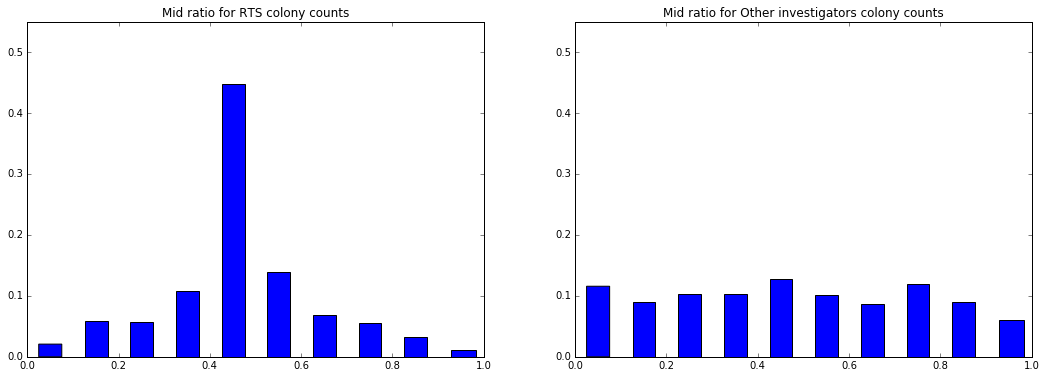

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

tmp1 = [(x[1] - x[0])*1.0/max(x[2] - x[0],1) for x in cleanData1]
tmp2 = [(x[1] - x[0])*1.0/max(x[2] - x[0],1) for x in cleanData2]
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
counts, bins, ignored = plt.hist(tmp1, [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01], 
                                 rwidth=0.5, weights=np.zeros_like(tmp1) + 1. / len(tmp1))
plt.ylim(0, .55)
plt.title('Mid ratio for RTS colony counts')
plt.subplot(1, 2, 2)
counts, bins, ignored = plt.hist(tmp2, [0, .101, .201, .301, .401, .501, .601, .701, .801, .901, 1.01],
                                 rwidth=0.5, weights=np.zeros_like(tmp2) + 1. / len(tmp2))
plt.ylim(0, .55)
plt.title('Mid ratio for Other investigators colony counts')
plt.show()
# print(bins)
# print(counts)

<a id = 'Poisson_test'></a>
# Poisson test

In [143]:
inv_coulter

,Bates No.,Date,col1,col2,col3,Average,Investigator
0,NaN,1992-04-15,1547.0,1574.0,1523.0,1548.000000,I
1,NaN,1992-04-15,1617.0,1552.0,1570.0,1579.666667,I
2,NaN,1992-04-15,1258.0,1279.0,1284.0,1273.666667,I
3,NaN,1992-04-15,1273.0,1313.0,1286.0,1290.666667,I
4,NaN,1992-04-15,1071.0,1044.0,1044.0,1053.000000,I
5,NaN,1992-04-15,1014.0,1014.0,965.0,997.666667,I
6,NaN,1992-04-15,1051.0,1012.0,990.0,1017.666667,I
7,NaN,1992-04-15,948.0,954.0,918.0,940.000000,I
8,NaN,1992-04-15,1039.0,977.0,1060.0,1025.333333,I
9,NaN,1992-04-15,2023.0,1851.0,1830.0,1901.333333,I


In [164]:
inv_raw = []
for idx in inv_coulter.index:
    triple = list(inv_coulter.loc[idx,'col1':'col3'])
    if np.isnan(triple[0]) or np.isnan(triple[1]) or np.isnan(triple[2]):
        continue
    if np.max(triple) - np.min(triple) > 2:
        inv_raw.append(triple)

In [127]:
def simulate_triple(lams):
    simu_triples = [np.random.poisson(lam=i, size=3).tolist() for i in lams]
    # var_triple = [np.var(triple) for triple in simu_triples]
    # mean_triple =  [np.mean(triple) for triple in simu_triples]
    return simu_triples

In [128]:
def regress(x, y):
    '''
    regress y = alpha * x with no intercept
    Inputs:
      x: list/array covariate
      y: list/array response
    Outputs:
      alpha: slope
    '''
    import numpy as np
    a = np.sum([i**2 for i in x])
    b = np.sum([i*j for i, j in zip(x, y)])
    return b/a

In [129]:
def TriplePoissonTest(data, verbose = True, plot = True, replicate = 20):
    '''
     Test whether given list of triples come from Poisson test
     Inputs:
       data: list of triples, integer
       verbose: boolean whether to print information
       plot: boolean whether to plot the figure
     Outputs:
       prob: probability whether the null hypothesis that triples are from poisson holds for this specific test.
    '''
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    sampleMean = [np.mean(x) for x in data]
    sampleVar  = [np.var(x)*3/2 for x in data]
    maxMean = np.max(sampleMean)
    minMean = np.min(sampleMean)
    slope = regress(sampleMean, sampleVar)
    if plot: 
        plt.figure(figsize=(18, 10)) # set figure size
        plt.subplot(3, 7, 1)
        plt.scatter(sampleMean, sampleVar)
        plt.xlim(minMean, maxMean)
        plt.ylim(minMean, maxMean*2)
        plt.plot([minMean, maxMean], [slope * minMean, slope * maxMean])
        plt.title('empirical')
        # plt.show()
    slopeList = []
    for i in range(replicate):
        simu = simulate_triple(random.sample(sampleMean, len(data)))
        sampleMean = [np.mean(x) for x in simu]
        sampleVar  = [np.var(x)*3/2 for x in simu]
        maxMean = np.max(sampleMean)
        minMean = np.min(sampleMean)
        slopeList.append(regress(sampleMean, sampleVar))
        if plot: 
            plt.subplot(3, 7, i + 2)
            plt.scatter(sampleMean, sampleVar)
            plt.xlim(minMean, maxMean)
            plt.ylim(minMean, maxMean*2)
            plt.plot([minMean, maxMean], [minMean, maxMean])
            plt.title('simulated ' + str(i))
    plt.show()
    if verbose: print(sum([i < slope for i in slopeList]), ' out of ', replicate, ' simulations have higer slopes than empirical.')
    return slopeList

In [149]:
slopeList = TriplePoissonTest(inv_raw,plot=False,replicate=1000, verbose=False)

In [179]:
len(slopeList)

1000

In [176]:
maxCount = np.max([val for sublist in inv_raw for val in sublist])


meanList = []
varList = []
for trip in inv_raw:
    xbar = np.mean(trip)
    ssbar = np.var(trip,ddof=1)
    
    if ssbar < 3 * maxCount:
        meanList.append(xbar)
        varList.append(ssbar)
        
slopeReal = regress(meanList,varList)

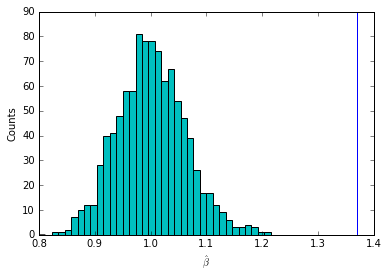

In [178]:
plt.hist(slopeList,color='c',bins=np.linspace(0.80,1.25,40))
plt.axvline(slopeReal)
plt.ylabel('Counts')
plt.xlabel(r'$\hat \beta$')
plt.savefig('/Users/ajstern/Documents/stat215a/stat215a-review/regression.pdf',format='pdf')

(0, 10000, 0, 20000)

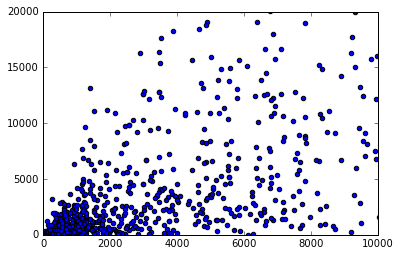

In [174]:
plt.scatter(xbar,ssbar)
plt.axis((0,10000,0,20000))